# Face Detection Project

In [2]:
import torch

import torchvision.transforms as transforms 

import numpy as np 
import pathlib 
from PIL import Image 
import matplotlib.pyplot as plt
import os 

from torch.utils.data import DataLoader 
from torch.utils.data import Dataset



# Not display warnings 
import warnings 
warnings.filterwarnings("ignore")



# Step 1: Prepare the Dataset

In [3]:
!gdown 1Hyjw3H3VyodhE3g7Bmv_hVTr7Xne65MI

Downloading...
From: https://drive.google.com/uc?id=1Hyjw3H3VyodhE3g7Bmv_hVTr7Xne65MI
To: /content/Face_Mask_Detect.zip
100% 171M/171M [00:03<00:00, 45.3MB/s]


In [4]:
from zipfile import ZipFile 
file_name = '/content/Face_Mask_Detect.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
cd /content/data

/content/data


In [6]:
with_mask_path = pathlib.Path('with_mask')
with_mask_file = sorted([str(path) for path in with_mask_path.glob('*.jpg')])
print(with_mask_file[:5])

['with_mask/with_mask_1.jpg', 'with_mask/with_mask_10.jpg', 'with_mask/with_mask_100.jpg', 'with_mask/with_mask_1000.jpg', 'with_mask/with_mask_1001.jpg']


In [7]:
without_mask_path = pathlib.Path('without_mask')
without_mask_file = sorted([str(path) for path in without_mask_path.glob('*.jpg')])
print(without_mask_file[:5])

['without_mask/without_mask_1.jpg', 'without_mask/without_mask_10.jpg', 'without_mask/without_mask_100.jpg', 'without_mask/without_mask_1000.jpg', 'without_mask/without_mask_1001.jpg']


In [8]:
print(f'Number of with mask images: {len(with_mask_file)}')
print(f'Number of without mask images: {len(without_mask_file)}')

Number of with mask images: 3725
Number of without mask images: 3828


In [44]:
file_list = with_mask_file + without_mask_file
print(len(file_list))

7553


### Creating labels for two class of images 


- With mask ---> 1 
- Without mask --> 0

In [45]:
# create the labels 
with_mask_labels = [1]*len(with_mask_file)
without_mask_labels = [0]*len(without_mask_file)

labels = with_mask_labels + without_mask_labels

# Convert the list to a tensor
labels = torch.tensor(labels)

print(type(labels))
print(len(labels))

<class 'torch.Tensor'>
7553


### Visualizing the images

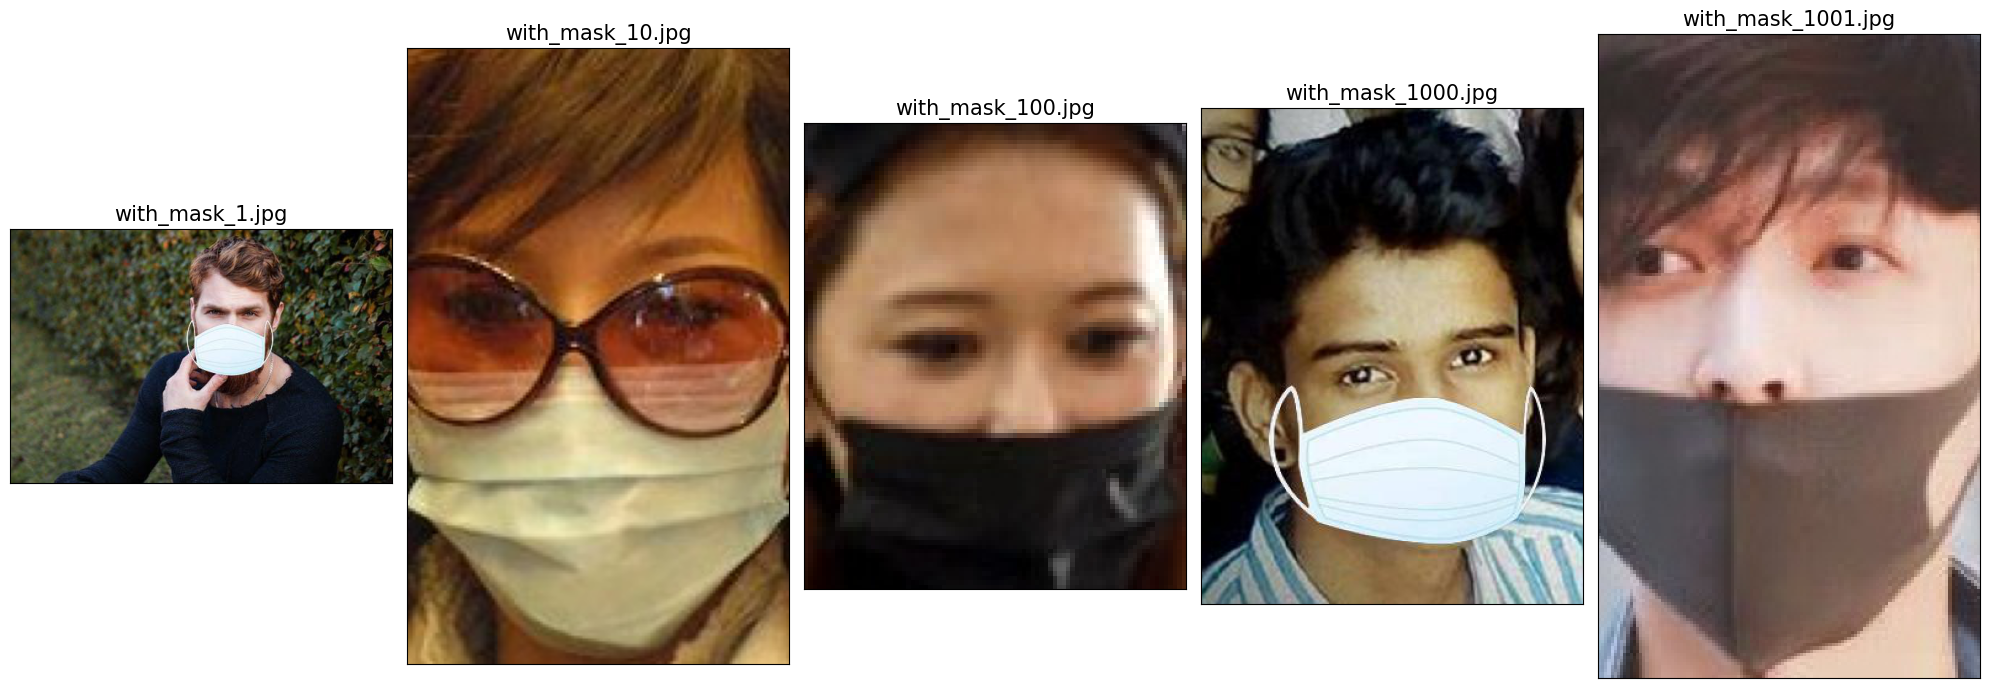

In [76]:
fig = plt.figure(figsize = (20, 18))

for i, file in enumerate(with_mask_file[:5]):
  img = Image.open(file)
  ax = fig.add_subplot(1, 5, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(img)
  ax.set_title(os.path.basename(file), size = 15)

plt.tight_layout()
plt.show()


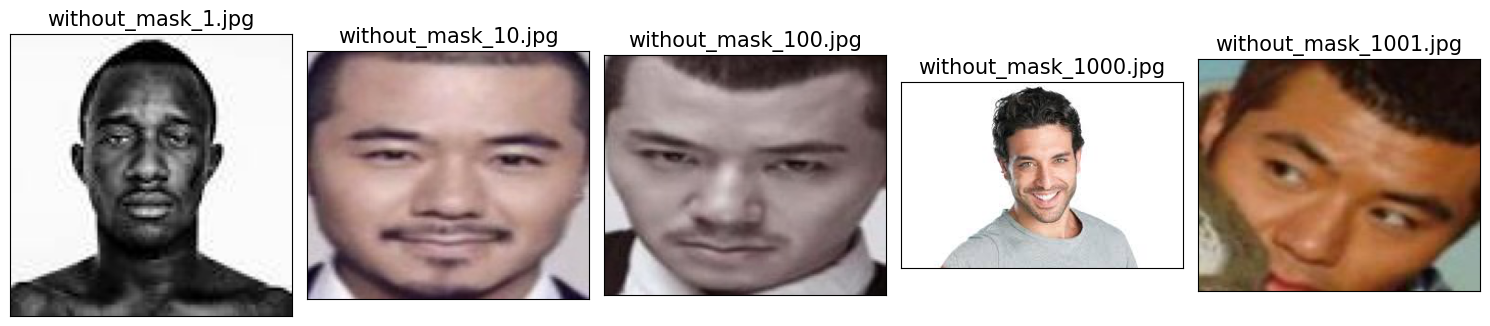

In [118]:
fig = plt.figure(figsize = (15, 7))

for i, file in enumerate(without_mask_file[:5]):
  img = Image.open(file)
  ax = fig.add_subplot(1, 5, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(img)
  ax.set_title(os.path.basename(file), size = 15)

plt.tight_layout()
plt.show()


Lets apply transformations to this dataset:

- resize to a size of 128 $\times$ 128
- convert to tensors (will also normalize into range (0,1)
- normalize

In [78]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [79]:
class MaskDataset(Dataset):
  def __init__(self, file_list, labels,  transform = None):
    self.file_list = file_list
    self.labels = labels
    self.transform = transform # function 
  
  def __getitem__(self,index):
    img = Image.open(self.file_list[index])
    if self.transform is not None:
      img = self.transform(img)
    label = self.labels[index]
    return img, label
  
  def __len__(self):
    return len(self.labels)


In [80]:
mask_dataset = MaskDataset(file_list, labels, transform)

print(len(mask_dataset))

7553


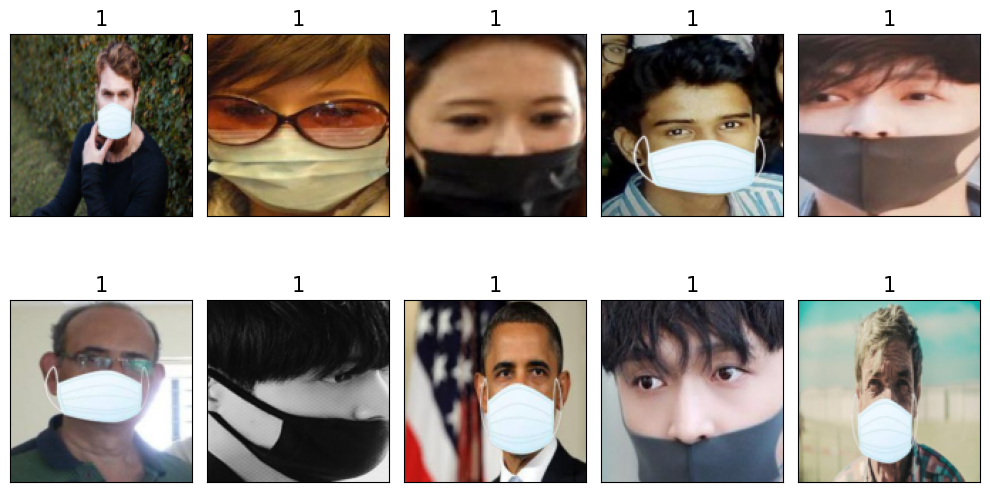

In [81]:
from itertools import islice

fig = plt.figure(figsize=(10, 6))
num_subplots = min(10, len(mask_dataset))  # Ensure the number of subplots is within the valid range

for i, example in enumerate(islice(mask_dataset, num_subplots)):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow((example[0] / 2 + 0.5).numpy().transpose((1, 2, 0)))
    ax.set_title(f'{example[1]}', size=15)

plt.tight_layout()
plt.show()


Next, lets define the dataloader with batches of 32 images for the training set.



In [103]:
from torch.utils.data import random_split, DataLoader

# Define the ratio of the dataset to be used for training and testing
train_ratio = 0.8  # 80% for training, 20% for testing
validation_ratio = 0.1  # 10% for validation
test_ratio = 1 - train_ratio - validation_ratio

# Calculate the number of samples for training, validation, and testing based on the ratios
train_size = int(train_ratio * len(mask_dataset))
validation_size = int(validation_ratio * len(mask_dataset))
test_size = len(mask_dataset) - train_size - validation_size

# Split the dataset into training, validation, and testing sets
train_dataset, validation_dataset, test_dataset = random_split(mask_dataset, [train_size, validation_size, test_size])

batch_size = 32

torch.manual_seed(1)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dl = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In this example, train_dataset is your original training dataset. We use the SubsetRandomSampler to create two separate samplers: one for the training data (train_sampler) and one for the validation data (val_sampler). The train_sampler selects random samples from the indices after the split point, while the val_sampler selects random samples from the indices before the split point. Finally, we create the DataLoader objects train_dl and val_dl using the respective samplers.


Note that we use the sampler argument instead of the shuffle argument in the DataLoader initialization for the validation set, as we want to sample the validation set without shuffling the samples.

In [104]:
import torch.nn as nn

num_of_classes = 2

model = nn.Sequential()

model.add_module(
    'conv1', 
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3))
)
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=(2, 2)))

model.add_module(
    'conv2',
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
)
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=(2, 2)))

model.add_module('flatten', nn.Flatten())

model.add_module('fc1', nn.Linear(64 * 30 * 30, 128))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(128, 64))
model.add_module('dropout2', nn.Dropout(p=0.5))
model.add_module('fc3', nn.Linear(64, num_of_classes))
model.add_module('sigmoid', nn.Sigmoid())



In [105]:
device = torch.device("cuda:0")
model = model.to(device)

In [106]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [107]:
# Set the device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) # Convert to float tensor
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device)  # Convert to float tensor
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [109]:
num_epochs = 5

# Set the random seed for reproducibility
torch.manual_seed(1)

# Train the model
hist = train(model, num_epochs, train_dl, validation_dl)


Epoch 1 accuracy: 0.8918 val_accuracy: 0.8861
Epoch 2 accuracy: 0.9118 val_accuracy: 0.9232
Epoch 3 accuracy: 0.9331 val_accuracy: 0.9311
Epoch 4 accuracy: 0.9484 val_accuracy: 0.9272
Epoch 5 accuracy: 0.9598 val_accuracy: 0.9417


Let’s now visualize the learning curve and compare the training and validation loss and accuracies
after each epoch:

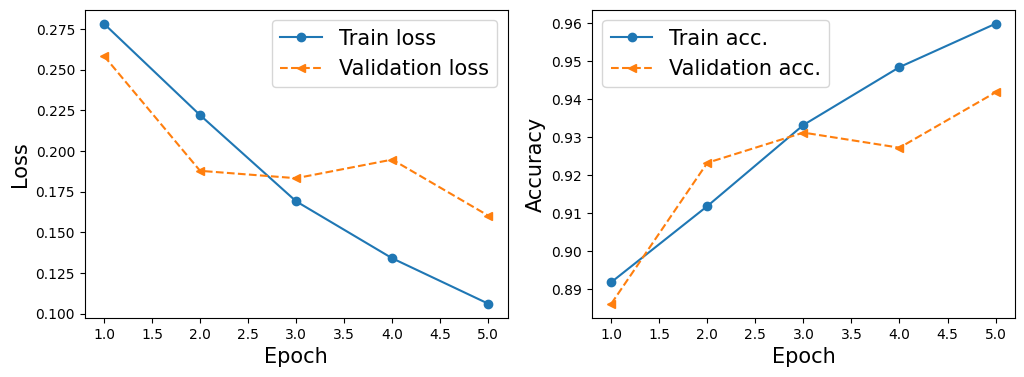

In [110]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_17.png', dpi=300)
plt.show()

In [111]:
accuracy_test = 0

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device) 
        y_batch = y_batch.to(device) 
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()
 
accuracy_test /= len(test_dl.dataset)
        
print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.9444


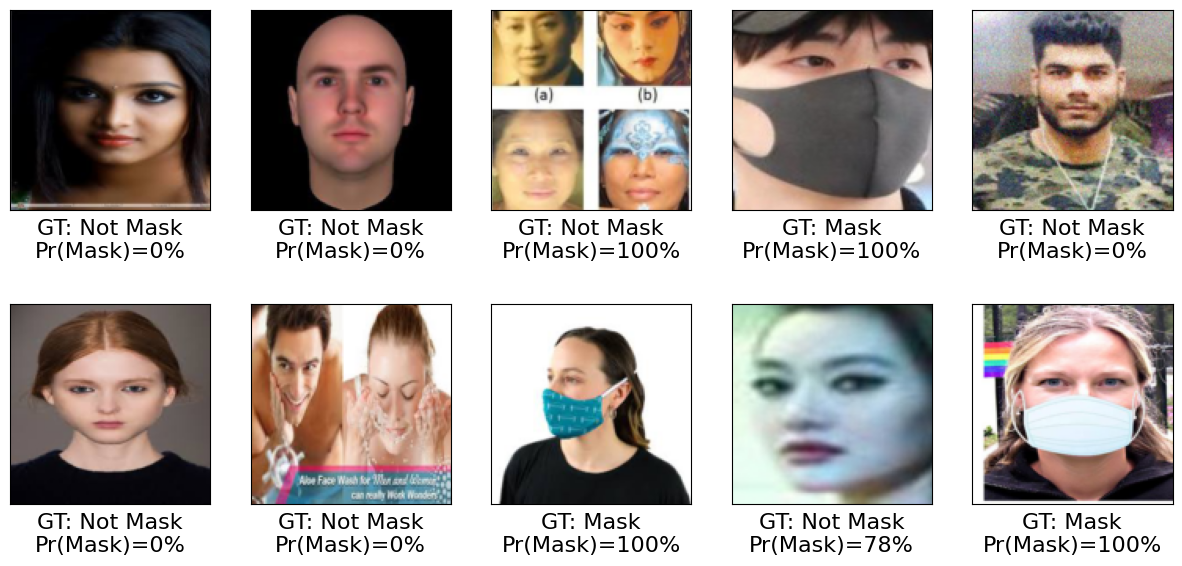

In [117]:
pred = model(x_batch)[:, 0] * 100

fig = plt.figure(figsize=(15, 7))

for j in range(len(x_batch[:10])):
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([]); ax.set_yticks([])
    
    # Check if the current index is within the actual batch size
    if j < len(x_batch):
        ax.imshow((x_batch[j]/2+0.5).cpu().permute(1, 2, 0))
        ax.imshow((x_batch[j]/2+0.5).cpu().permute(1, 2, 0))
        if y_batch[j] == 1:
            label = 'Mask'
        else:
            label = 'Not Mask'
        ax.text(
            0.5, -0.15, 
            f'GT: {label:s}\nPr(Mask)={pred[j]:.0f}%', 
            size=16, 
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    else:
        # Handle the case when the current index is out of bounds
        ax.axis('off')
    
#plt.savefig('figures/figures-14_18.png', dpi=300)
plt.show()

### Saving the model

In [120]:
import os
if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/face-mask-cnn.ph'
torch.save(model, path)